In [2]:
# Lets imports all the necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,DoubleType,TimestampType,VarcharType
from pyspark.sql.functions import *
import requests

In [15]:
filename1 = datetime.now().strftime("%Y%m%d-%H%M%S")
filename1


str

## Creating SPARK session

- created multiple session and worked on SPARK UI
- 

In [10]:
spark = SparkSession.builder.appName('Session3').getOrCreate()

## Extract and Transform Branch Data
- reaching the jason file was straight forward in spark as it reads attributes without any problem.\
- Challange: requirement to chage the formate of the phone numbers and change the column sequencing
    - attempts: tried spark map function, lambda functions unsuccessfully. 
    - Also tried to convert in to PANDAS DF but it was too long and ineffiecient as I am getting data back from clusters to local node.
    - solution: It was more efficienct to use SPARK RDD to do both task at the same time. 

In [11]:
def prepare_branchdf(file):
    '''Take jason file for branch as input and return updated DF as per requirements'''
    
    # load json file and create spark DF
    branch_df = spark.read.json(file)

    # fill null zip column values with 99999 according to requirements
    branch_df.na.fill(99999, ['BRANCH_ZIP'])

    # rearrange columns + create branch_phone format according to requirements: USING INDEX
    rdd2 = branch_df.rdd.map(lambda x: (x[1],x[2],x[5], x[0], x[4], x[6], \
                                        '('+x[3][:3]+')' + x[3][3:6] + "-"+ x[3][6:],\
                                            x[7]))

    # rename the columns according to requirements
    df2 = rdd2.toDF([
    'BRANCH_CODE',
    'BRANCH_NAME',
    'BRANCH_STREET',
    'BRANCH_CITY',
    'BRANCH_STATE',
    'BRANCH_ZIP',
    'BRANCH_PHONE',
    'LAST_UPDATED'])
    

    # update columns type according to requirements 
    updated_branch_df = df2.withColumn("BRANCH_CODE",df2["BRANCH_CODE"].cast(IntegerType()))\
        .withColumn("BRANCH_NAME",df2["BRANCH_NAME"].cast(VarcharType(40)))\
        .withColumn("BRANCH_STREET",df2["BRANCH_STREET"].cast(VarcharType(40)))\
        .withColumn("BRANCH_CITY",df2["BRANCH_CITY"].cast(VarcharType(40)))\
        .withColumn("BRANCH_STATE",df2["BRANCH_STATE"].cast(VarcharType(40)))\
        .withColumn("BRANCH_ZIP",df2["BRANCH_ZIP"].cast(IntegerType()))\
        .withColumn("BRANCH_PHONE",df2["BRANCH_PHONE"].cast(VarcharType(40)))\
        .withColumn("LAST_UPDATED",df2["LAST_UPDATED"].cast(TimestampType()))
    
    return updated_branch_df

## Extract and Transform Customer Data
- Challange 1 : original data had 7 digit phone number, requirement is to provide (XXX)XXX-XXXX formate
    - Attempt: it was easy to just replace with 124 or add 000 at the end of phone number but it was not appropriate
    - Attempt: to Join Customer city with Branch City data but so majority of customer does not fall in inner join and so will still have no AREA CODE
    - Solution: I have downloaded CSV file which has approx 3000 USA cities with their PHONE AREA CODE. I have created DF to late join with customer data to get area code.
- Challange 2: Downloaded USA Cities and Area Code file has cities name in TITLE formate with space in between. Whereas Customer Data has no spaces. 
    - Attempt: Used REGEX to match city data cities name to areacode cities name. Was not successfull as several cities have similar names but they were different.
    - Solution: Modified citi name column of Area code file to matach customer city data and they performed LEFT OUTER JOIN to get area code of customer. This way I was able to get 94% of all customer's AREA CODE in place. Remaining 5% had either City Name that were either fictionous or not available area codes. 
- Challange 3: Merge 2 columns, performed string concatenation, reaarange and rename column names.
    -Solution: Again converting to SPARK RDD and while converting back to SPARK DF can achive all require task together. 
    

In [12]:
def prepare_customerdf(file):
    '''Prepare customer dataframe from the file input'''
    
    # read CSV file that contains cities and phone area code
    df_cities = spark.read.csv('us-area-code-cities.csv', header=False)
    # since the CSV file have unnecessary columns, select first 2 columns that contains area code and cities name
    df_cities2 = df_cities.select(df_cities.columns[:2])
    # naming the columns
    df_cities3 = df_cities2.toDF('AREA_CODE', 'CITIES')
    # since the target DF CUST_CITY have cities name without spaces, lets remove spaces from here also to match
    df_cities3 = df_cities3.withColumn('CITIES', regexp_replace('CITIES', ' ', ''))


    # read json file for customer details
    customer_df = spark.read.json(file)
    # since CUST_PHONE column is int type, convert in str to be able to modify later
    customer_df = customer_df.withColumn("CUST_PHONE",customer_df["CUST_PHONE"].cast(StringType()))
    # make sure there is not city name with space, so remove spaces
    customer_df = customer_df.withColumn('CUST_CITY', regexp_replace('CUST_CITY', ' ', ''))


    # create the left from of customer df and df cities to get area codes in customer df 
    customer_df = customer_df.join(df_cities3, customer_df.CUST_CITY == df_cities3.CITIES ,"left")
    # we still have about 300/952 null values in area code, replace it with 123
    customer_df= customer_df.na.fill(value="123", subset=['AREA_CODE'])
    customer_df = customer_df.na.fill(99999, ['CUST_ZIP'])


    # create RDD to map each colum and transform as per requeirements:USING COLUMN NAME
    rdd3 = customer_df.rdd.map(lambda x: \
                               (x["SSN"], x["FIRST_NAME"].title(), x["MIDDLE_NAME"].lower(),\
                                x["LAST_NAME"].title(), x["CREDIT_CARD_NO"],\
                                x["STREET_NAME"]+ ', ' + x["APT_NO"],\
                                x["CUST_CITY"], x["CUST_STATE"], x["CUST_COUNTRY"], x["CUST_ZIP"],\
                                '('+ x["AREA_CODE"] +')' + x["CUST_PHONE"][:3] + '-' + x["CUST_PHONE"][3:],\
                                x["CUST_EMAIL"],x["LAST_UPDATED"]))
    
    # Name all the columns according to requirements
    updated_cust_df = rdd3.toDF([
                                'SSN',
                                'FIRST_NAME',
                                'MIDDLE_NAME',
                                'LAST_NAME',
                                'Credit_card_no',
                                'FULL_STREET_ADDRESS',
                                'CUST_CITY',
                                'CUST_STATE',
                                'CUST_COUNTRY',
                                'CUST_ZIP', 
                                'CUST_PHONE',
                                'CUST_EMAIL', 
                                'LAST_UPDATED' 
                                ])
    

    # update column types according to requirements
    updated_cust_df = updated_cust_df\
        .withColumn('SSN',updated_cust_df['SSN'].cast(IntegerType()))\
        .withColumn('FIRST_NAME',updated_cust_df['FIRST_NAME'].cast(VarcharType(40)))\
        .withColumn('MIDDLE_NAME',updated_cust_df['MIDDLE_NAME'].cast(VarcharType(40)))\
        .withColumn('LAST_NAME',updated_cust_df['LAST_NAME'].cast(VarcharType(40)))\
        .withColumn('Credit_card_no',updated_cust_df['Credit_card_no'].cast(VarcharType(18)))\
        .withColumn('FULL_STREET_ADDRESS',updated_cust_df['FULL_STREET_ADDRESS'].cast(VarcharType(40)))\
        .withColumn('CUST_CITY',updated_cust_df['CUST_CITY'].cast(VarcharType(25)))\
        .withColumn('CUST_STATE',updated_cust_df['CUST_STATE'].cast(VarcharType(25)))\
        .withColumn('CUST_COUNTRY',updated_cust_df['CUST_COUNTRY'].cast(VarcharType(25)))\
        .withColumn('CUST_ZIP',updated_cust_df['CUST_ZIP'].cast(IntegerType()))\
        .withColumn('CUST_PHONE',updated_cust_df['CUST_PHONE'].cast(VarcharType(25)))\
        .withColumn('CUST_EMAIL',updated_cust_df['CUST_EMAIL'].cast(VarcharType(40)))\
        .withColumn('LAST_UPDATED',updated_cust_df['LAST_UPDATED'].cast(TimestampType()))
        

    return updated_cust_df

## Extract and Transform Credit Transactions Data
-Challange1 :  3 different colums for Month, Date and Yeare was required to convenrt to YYYYMMDD formate for TIMEID. 
    - Attempt: It was easy to just concat these colums but they were int type not strings.
    - Attempt: Even after converting to string type, some of the MONTH and DAY colums were in single digit.. example. "8" instead of "08"
    - Attempt: tried FOR LOOP to see if it was signle digit to add "0" in front but it was not efficient as it take lots of time. 
    - Solution: Converted all 3 colums in to String type, used LPAD() functions with Select method to add 0 in front and thant use RDD to concat them.
    

In [13]:
def prepare_creditdf(file):
    '''takes credit json file and output requires DF'''

    # read file to create df
    credit_df = spark.read.json(file)

    # convert DAY MONTH and YEAE to string to be able to create YYYYMMDD formate in varchar type
    credit_df = credit_df\
        .withColumn('DAY',credit_df['DAY'].cast(StringType()))\
        .withColumn('MONTH',credit_df['MONTH'].cast(StringType()))\
        .withColumn('YEAR',credit_df['YEAR'].cast(StringType()))
    
    # since some DAY and MONTH values are single digit. lets left pad them with "0"
    credit_df = credit_df.select('BRANCH_CODE',
                                    'CREDIT_CARD_NO',
                                    'CUST_SSN',
                                    lpad(credit_df.DAY, 2, '0').alias("DAY"),
                                    lpad(credit_df.MONTH, 2, '0').alias("MONTH"),
                                    'TRANSACTION_ID',
                                    'TRANSACTION_TYPE',
                                    'TRANSACTION_VALUE',
                                    'YEAR')
    
    # create RDD to apply lambda function to 
    rdd_credit = credit_df.rdd.map(lambda x: (x[1], x[8]+x[4]+x[3] , x[2], x[0],\
                                        x[6], x[7], x[5]))
    
    #convert back to DF with required column names
    updated_credit_df = rdd_credit.toDF(['CUST_CC_NO',
                                        'TIMEID',
                                        'CUST_SSN',
                                        'BRANCH_CODE',
                                        'TRANSACTION_TYPE',
                                        'TRANSACTION_VALUE',
                                        'TRANSACTION_ID'])
    
    # update types of each colums according to requirements
    updated_credit_df = updated_credit_df\
        .withColumn('CUST_CC_NO',updated_credit_df['CUST_CC_NO'].cast(VarcharType(20)))\
        .withColumn('TIMEID',updated_credit_df['TIMEID'].cast(VarcharType(10)))\
        .withColumn('CUST_SSN',updated_credit_df['CUST_SSN'].cast(IntegerType()))\
        .withColumn('BRANCH_CODE',updated_credit_df['BRANCH_CODE'].cast(IntegerType()))\
        .withColumn('TRANSACTION_TYPE',updated_credit_df['TRANSACTION_TYPE'].cast(VarcharType(40)))\
        .withColumn('TRANSACTION_VALUE',updated_credit_df['TRANSACTION_VALUE'].cast(DoubleType()))\
        .withColumn('TRANSACTION_ID',updated_credit_df['TRANSACTION_ID'].cast(IntegerType()))
    
    return updated_credit_df

In [14]:
branch_df = prepare_branchdf("cdw_sapp_branch.json")

customer_df = prepare_customerdf("cdw_sapp_custmer.json")

credit_df = prepare_creditdf("cdw_sapp_credit.json")

In [21]:
credit_df.coalesce(1).write.json("creditdf")


## Loading Transformed Data in to CSV file
- Challange: loading the data into CSV file was giving error.
    - Attempt: tried changes syntax but continued the error. 
    - Attempt: checked all the system and user environmental variables. 
    - Attempt: error said:" pyspark   "An error occurred while calling o3561.json.\n: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0" SO  tried deleting wintils.exe from spark/bin folder and saving the newer version of wintils.exe but continue the error.
    - solution: It needed "hadoop.dll" files from https://github.com/steveloughran/winutils and saved the file in to spark/bin folder. 

- Challange How to make sure it does not make new file everytime we run the load
    - Solution: Used option "Overwrite" with df.write.csv.

In [8]:
# branch_df.write.option("header",True).csv("branchfile")

# customer_df.write.option("header",True).csv("customerfile")

# credit_df.write.option("header",True).csv("creditfile")

## Load data into RDBMS(SQL) in MySQL
- created new DB in MySQL and used jdbc connection after installing connector for mySql. 
 

In [7]:
# branch_df.write.format("jdbc") \
#   .mode("append") \
#   .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
#   .option("dbtable", "CDW_SAPP_BRANCH") \
#   .option("user", "root") \
#   .option("password", "Password") \
#   .save()


# customer_df.write.format("jdbc") \
#   .mode("append") \
#   .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
#   .option("dbtable", "CDW_SAPP_CUSTOMER") \
#   .option("user", "root") \
#   .option("password", "Password") \
#   .save()

# credit_df.write.format("jdbc") \
#   .mode("append") \
#   .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
#   .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
#   .option("user", "root") \
#   .option("password", "Password") \
#   .save()

In [8]:
customer_df.count()

customer_df.show(5)

branch_df.show(5)

credit_df.show(5)

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(123)123-7818|AHooper@example.com|2018-04-21 12:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  Redwood Drive, 829|Wethersfield|        CT|United States|    6109|(959)123-8933|EHolman@example.com|2018-04-21 12:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  Redwood Drive, 82

## Functional Requirements:
- Joining DF using pyspark methods, dropDuplicates 

In [9]:
# 211 Used to display the transactions made by customers living 
# in a given zip code for a given month and year. Order by day in descending order.
# 53151  2018  08
# used Regex df.column.like , used inner joint between credit df and customer df.

def req211():
    '''display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order'''
    a = input("Please enter zip code: ")
    b = input("Enter Year: ") + input("Enter Month: ") + "%"

    result211_df= credit_df.join(customer_df, credit_df.CUST_CC_NO == customer_df.Credit_card_no)\
                        .select("TRANSACTION_ID", "TRANSACTION_VALUE","TRANSACTION_TYPE","CUST_ZIP","TIMEID")\
                        .filter((col("CUST_ZIP") == a) & (credit_df.TIMEID.like(b)))\
                        .dropDuplicates()\
                        .sort(col("TIMEID").desc())
    
    return result211_df

df211 = req211()
df211.show()


+--------------+-----------------+----------------+--------+--------+
|TRANSACTION_ID|TRANSACTION_VALUE|TRANSACTION_TYPE|CUST_ZIP|  TIMEID|
+--------------+-----------------+----------------+--------+--------+
|         28982|            77.65|   Entertainment|   53151|20180827|
|         13625|            46.97|   Entertainment|   53151|20180825|
|         13632|            70.46|             Gas|   53151|20180824|
|         28957|            63.59|         Grocery|   53151|20180824|
|         13660|            78.97|         Grocery|   53151|20180824|
|         27595|            68.33|             Gas|   53151|20180823|
|         28939|            74.66|           Bills|   53151|20180822|
|         46110|            58.94|         Grocery|   53151|20180822|
|         27568|            17.77|             Gas|   53151|20180821|
|         46065|            41.74|       Education|   53151|20180821|
|         27607|             68.2|            Test|   53151|20180821|
|         13676|    

In [10]:
# Used to display the number and total values of transactions for a given type.
# used input number method to pick the type of transactions. Used aggregate method to count and sum as well as alias method to name the colums.

def req212():

    a = input("""1. Bills \n
               2. Healthcare \n
               3. Gas \n
               4. Education \n
               5. Test \n
               6. Entertainment \n
               7. Grocery \n
               .....Enter Number for type of trasaction: """)
    dict = {"1":"Bills","2":"Healthcare", 
            "3":"Gas", "4":"Education", 
            "5":"Test", "6":"Entertainment", 
            "7":"Grocery"}
    result212_df = credit_df.filter(credit_df.TRANSACTION_TYPE == dict[a])\
                        .groupby("TRANSACTION_TYPE")\
                        .agg(
                            count("TRANSACTION_TYPE").alias("NUMBER_OF_TRANSACTION"), 
                            round(sum("TRANSACTION_VALUE"),2).alias("TOTAL_VALUES_OF_TRANSACTION")
                            )
    return result212_df
    


df212 = req212()
df212.show()

# Choose from: Bills, Healthcare, Gas, Education, Test, Entertainment, Grocery

+----------------+---------------------+---------------------------+
|TRANSACTION_TYPE|NUMBER_OF_TRANSACTION|TOTAL_VALUES_OF_TRANSACTION|
+----------------+---------------------+---------------------------+
|             Gas|                 6605|                  336059.26|
+----------------+---------------------+---------------------------+



In [11]:
# 213 Used to display the total number and total values of transactions for branches in a given state.
# used join and grouby as well as aggragate functions.

def req213():
    '''display the total number and total values of transactions for branches in a given state'''
    state_code = input("Please input 2 letters STATE code: ").upper()
    result213_df =  credit_df.join(branch_df, credit_df.BRANCH_CODE == branch_df.BRANCH_CODE)\
                        .filter(col("BRANCH_STATE") == state_code)\
                        .groupby("BRANCH_STATE")\
                        .agg(
                            count(credit_df.TRANSACTION_VALUE).alias("Number_of_Transaction"),
                            round(sum(credit_df.TRANSACTION_VALUE),2).alias("Total_Value_of_Transaction")
                            )
    return result213_df

df213 = req213()
df213.show()
        

+------------+---------------------+--------------------------+
|BRANCH_STATE|Number_of_Transaction|Total_Value_of_Transaction|
+------------+---------------------+--------------------------+
|          NY|                 4143|                 213717.38|
+------------+---------------------+--------------------------+



In [12]:
# 221 Used to check the existing account details of a customer.
# Since it was not specified what to input to get the detais, I have created option to input first, last name, SSN or CC number.. anything will work. 
# (123)124-3018, 4210653310116272, Wilber Dunham, 123454487

def req221():
    '''to check the existing account details of a customer.'''
    first_name = input("First Name: ")
    last_name = input("Last Name: ")
    ssn = input("SSN: ")
    ccnumber = input("Credit Cart Number: ")

    if len(ssn) != 0 or len(ccnumber) != 0:
        result221_df = customer_df.filter((col("SSN") == ssn) | (col("Credit_card_no") == ccnumber))
    elif len(first_name) != 0 and len(last_name) != 0:
        result221_df= customer_df.filter((col("FIRST_NAME") == first_name) & (col("LAST_NAME") == last_name))\
                                .dropDuplicates()
    elif len(first_name) != 0 or len(last_name) != 0:
        result221_df= customer_df.filter((col("FIRST_NAME") == first_name) | (col("LAST_NAME") == last_name))\
                                .dropDuplicates()
    return result221_df


df221 = req221()
df221.show()

+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+-------------------+
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Street East,...|  Huntley|        IL|United States|   60142|(123)124-3018|WDunham@example.com|2018-04-21 12:49:02|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------+-------------------+-------------------+



In [ ]:
# 222 to modify the existing account details of a customer. ask for enter all numbers you want to update after entering SSN
# Challanging: as needed to create program that let us change anything we want to as the same time... used combination of python dictionary, for loop
# to name shorted possible code.
# once all numbers entered, split to make list to check if that number is in the list.


def req222():
    '''to modify the existing account details of a customer'''
    ssn = (int(input("Modify Customer Detail. What is SSN of the Customer: ")))

    # you can also use f string below to show current details of customer 
    details = list(input("enter all letters that needed to be modified (reference below):\n\
a. 'FIRST_NAME',\n b. 'MIDDLE_NAME',\n c. 'LAST_NAME',\n d. 'FULL_STREET_ADDRESS',\n e. 'CUST_CITY',\n\
f. 'CUST_STATE',\n g. 'CUST_COUNTRY',\n h. 'CUST_ZIP',\n i. 'CUST_PHONE',\n j. 'CUST_EMAIL'\n \
ENTER THE LETTER/LETTERS: "))
    
    dict1 = {'a':'FIRST_NAME','b':'MIDDLE_NAME','c':'LAST_NAME', 'd':'FULL_STREET_ADDRESS',\
            'e':'CUST_CITY', 'f':'CUST_STATE', 'g':'CUST_COUNTRY','h':'CUST_ZIP', 'i':'CUST_PHONE', 'j':'CUST_EMAIL'}
    
    df2 = customer_df
    
    for letter in details:
        newdetail = (input(f"New {dict1[letter]}: "))
        df2 = df2.withColumn(dict1[letter], when(col("SSN")== ssn , newdetail).otherwise(df2[dict1[letter]]))
        df2 = df2.withColumn("LAST_UPDATED", when(col("SSN")== ssn , from_unixtime(current_timestamp().cast("long"))).otherwise(df2.LAST_UPDATED))

    return df2
    
df222 = req222()
df222.show()

In [13]:
# 223 Used to generate a monthly bill for a credit card number for a given month and year.
# Since it does not indicate how the monthly bill look like, whether to include all transaction and also total of the monthly trasactions.
# came up with my own way to create the bill on console. 
# also used to_date function to convert TIMEID to Date MM-DD-YYYY formate.
# sample: 4210653349028689     2018  08
def req223():
    '''to generate a monthly bill for a credit card number for a given month and year.'''
    billccno = input("Please enter Credit Card number without dashes for monthly bill: ")
    billyear = input("Enter the Year: ")
    billmonth = input("Enter the Month: ")
    timeidlike = billyear + billmonth + "%"
    firstname = customer_df.filter(col("Credit_card_no") == billccno).head()[1]
    middlename = customer_df.filter(col("Credit_card_no") == billccno).head()[2]
    lastname = customer_df.filter(col("Credit_card_no") == billccno).head()[3]
    addressstreet = customer_df.filter(col("Credit_card_no") == billccno).head()[5]
    addresscity = customer_df.filter(col("Credit_card_no") == billccno).head()[6]
    addressstate = customer_df.filter(col("Credit_card_no") == billccno).head()[7]
    addresszip = customer_df.filter(col("Credit_card_no") == billccno).head()[9]
                                                                          
    
    print(f"MONTHLY BILL FOR {firstname} {lastname} ")
    print()
    # below code can be upgraded to include if statement so month does not become 13 
    print(f"Billing Period: {billmonth}-01-{billyear} to {int(billmonth) + 1}-01-{billyear}")
    print()
    print(firstname," ",middlename.title()," ",lastname)
    print(addressstreet,",")
    print(addresscity,", ",addressstate," ",addresszip)
    print()
    print("+-------------------------+\n|   MINIMUM PAYMENT DUE   |\n+-------------------------+\n|          $15.00         |\n+-------------------------+")
    print()
    resultdf = credit_df.filter((col("CUST_CC_NO") == billccno) & (credit_df.TIMEID.like(timeidlike)))\
            .withColumn("Date", to_date(col("TIMEID"), "yyyyMMdd"))\
            .select("Date", "TRANSACTION_TYPE", "TRANSACTION_VALUE", "TRANSACTION_ID")
    resultdf2 = resultdf.agg(round(sum(credit_df.TRANSACTION_VALUE),2).alias("Total_MONTHLY_PAYMENT_DUE"))
    print(resultdf2.show())
    return resultdf

df9 = req223()
df9.show()



MONTHLY BILL FOR Amalia Campos 

Billing Period: 08-01-2018 to 9-01-2018

Amalia   Hal   Campos
Valley Drive, 774 ,
Harleysville ,  PA   19438

+-------------------------+
|   MINIMUM PAYMENT DUE   |
+-------------------------+
|          $15.00         |
+-------------------------+

+----------+----------------+-----------------+--------------+
|      Date|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------+----------------+-----------------+--------------+
|2018-08-08|             Gas|            95.39|             8|
|2018-08-21|             Gas|            98.75|            11|
|2018-08-13|       Education|              6.7|            22|
|2018-08-06|      Healthcare|            98.78|            28|
|2018-08-26|      Healthcare|            26.34|            49|
|2018-08-09|           Bills|            13.72|            58|
|2018-08-11|       Education|            82.11|            66|
|2018-08-25|            Test|            17.12|            88|
|2018-08-03|       Edu

In [17]:
# 224 Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.
# how to used TIMEID and compate with Date input.
# 4210653349028689  09-01-2018    12-31-2018

def req224():
    '''to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.'''
    custcc = input("Please enter customer Credit Card Number wihtout Dashes: ")
    startdate = (input("Enter Starting date MM-DD-YYYY formate: "))
    enddate = (input("Enter Ending date MM-DD-YYYY formate: "))
    starting_date = startdate[6:] + startdate[0:2] + startdate[3:5]
    ending_date = enddate[6:] + enddate[0:2] + enddate[3:5]
    result224_df = credit_df.filter((col("TIMEID") > starting_date ) & (col("TIMEID") < ending_date ))\
                            .filter(col("CUST_CC_NO") == custcc)\
                            .withColumn("Date", to_date(col("TIMEID"), "yyyyMMdd"))\
                            .sort(col("TIMEID").desc())\
                            .select("CUST_CC_NO", "Date", "BRANCH_CODE", "TRANSACTION_TYPE", "TRANSACTION_VALUE","TRANSACTION_ID")
    return result224_df

df224 = req224()
df224.show()

+----------------+----------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|      Date|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+----------+-----------+----------------+-----------------+--------------+
|4210653349028689|2018-12-24|         17|             Gas|            42.71|            12|
|4210653349028689|2018-12-22|        121|       Education|            43.08|            63|
|4210653349028689|2018-12-21|        158|      Healthcare|            30.58|            55|
|4210653349028689|2018-12-18|         42|             Gas|            38.07|            75|
|4210653349028689|2018-12-14|         19|            Test|            82.05|            27|
|4210653349028689|2018-12-12|         66|       Education|            13.34|            32|
|4210653349028689|2018-12-09|         80|   Entertainment|            15.89|            52|
|4210653349028689|2018-12-04|         29|             Gas|            17.03|    

In [8]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [19]:
# Find and plot which transaction type has a high rate of transactions.
# Note: Take a screenshot of the graphs. 


transaction_type_df = credit_df.select(col("TRANSACTION_TYPE"))\
        .groupby("TRANSACTION_TYPE")\
        .agg(count(credit_df.TRANSACTION_TYPE).alias("Number_of_Transaction"))

        
pd_transaction_type_df = transaction_type_df.toPandas()

pd_transaction_type_df.set_index("TRANSACTION_TYPE", inplace=True)



,Number_of_Transaction
TRANSACTION_TYPE,
Education,6638
Entertainment,6635
Healthcare,6723
Grocery,6549
Test,6683


                  Number_of_Transaction
TRANSACTION_TYPE                       
Education                          6638
Entertainment                      6635
Healthcare                         6723
Grocery                            6549
Test                               6683


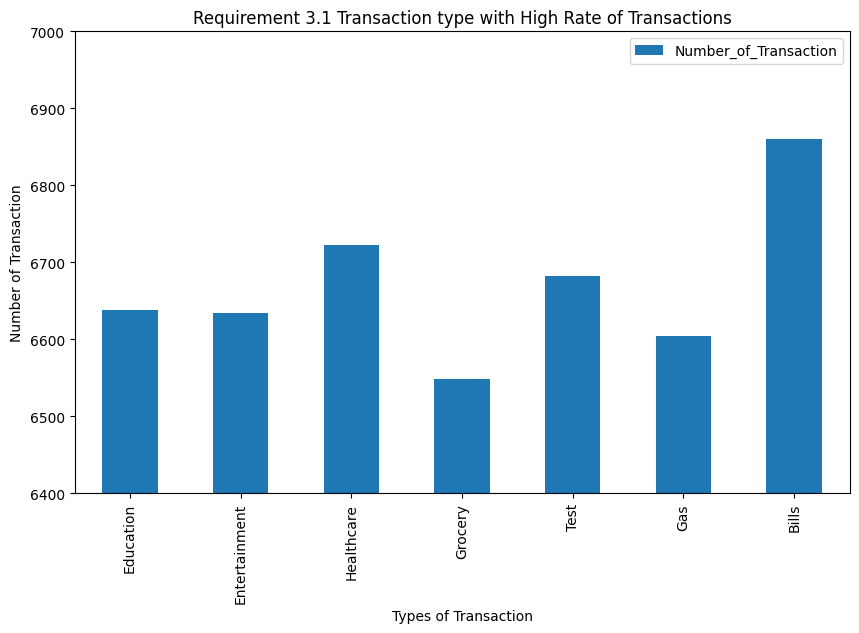

In [52]:
pd_transaction_type_df.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Types of Transaction') # add to x-label to the plot
plt.ylabel('Number of Transaction') # add y-label to the plot
plt.title('Requirement 3.1 Transaction type with High Rate of Transactions') # add title to the plot
plt.ylim(6400,7000)
print(pd_transaction_type_df.head())
plt.show()

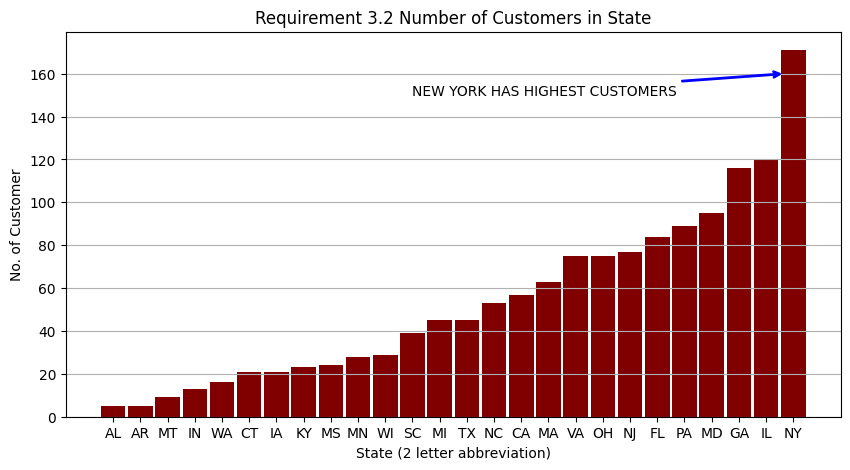

In [31]:
# Find and plot which state has a high number of customers.

state_df = customer_df.groupBy("CUST_STATE").count().orderBy("count").toPandas()

fig = plt.figure(figsize = (10, 5))

plt.bar(state_df["CUST_STATE"], state_df["count"], color ='maroon',
        width = 0.9)

plt.xlabel("State (2 letter abbreviation)")
plt.ylabel("No. of Customer")
plt.title("Requirement 3.2 Number of Customers in State")
plt.grid(axis="y")

plt.annotate('NEW YORK HAS HIGHEST CUSTOMERS',  # s: str. Will leave it blank for no text
             xy=(24.7, 160),  # place head of the arrow at point (year 2012 , pop 70)
             xytext=(11, 150),  # place base of the arrow at point (year 2008 , pop 20)
             xycoords='data',  # will use the coordinate system of the object being annotated
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2)
             )

plt.show()

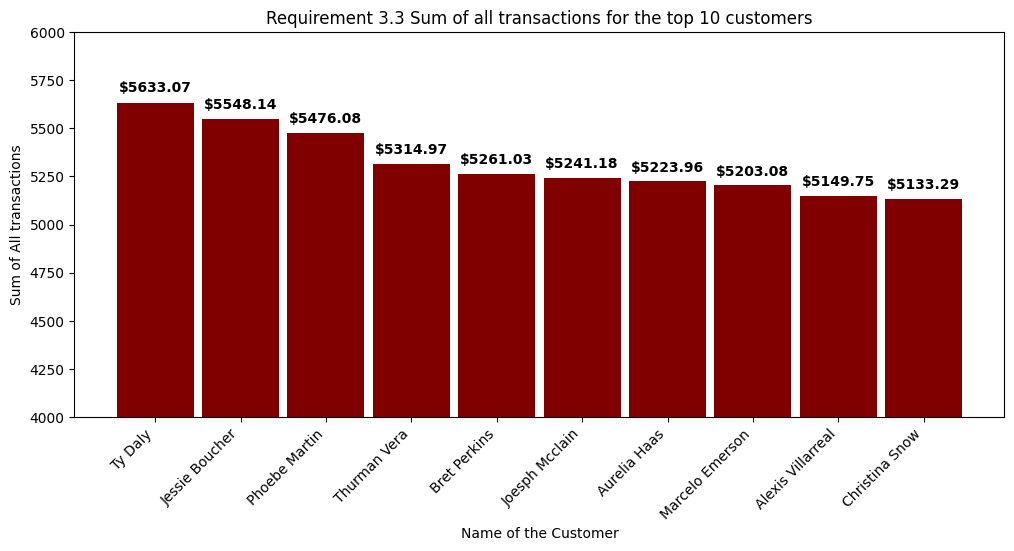

In [29]:
# Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.
#Hint (use CUST_SSN). 

top_customer_df = credit_df.groupBy("CUST_SSN").agg(round(sum("TRANSACTION_VALUE"),2).alias("TOTAL_TRANSACTION_VALUE"))

top_customer_df = top_customer_df.join(customer_df, top_customer_df.CUST_SSN == customer_df.SSN)\
    .select("FIRST_NAME", "LAST_NAME","TOTAL_TRANSACTION_VALUE")\
    .dropDuplicates()

top_customer_df = top_customer_df.withColumn("Full_Name", concat_ws(" ","FIRST_NAME", "LAST_NAME")).sort(col("TOTAL_TRANSACTION_VALUE").desc())\
    .limit(10).toPandas()

fig = plt.figure(figsize = (12, 5))

graph= plt.bar(top_customer_df["Full_Name"], top_customer_df["TOTAL_TRANSACTION_VALUE"], color ='maroon',width = 0.9)

plt.xticks(rotation = 45, ha="right")
plt.ylim(4000,6000)
plt.title("Requirement 3.3 Sum of all transactions for the top 10 customers")
plt.xlabel("Name of the Customer")
plt.ylabel("Sum of All transactions")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str('$' + str(top_customer_df["TOTAL_TRANSACTION_VALUE"][i])),
             ha='center',
             weight='bold')
    i+=1


plt.show()

  Month_of_Year_2018  TOTAL_NUMBER_OF_TRANSACTIONS
0           February                          3959
1            October                          3946
2                May                          3946


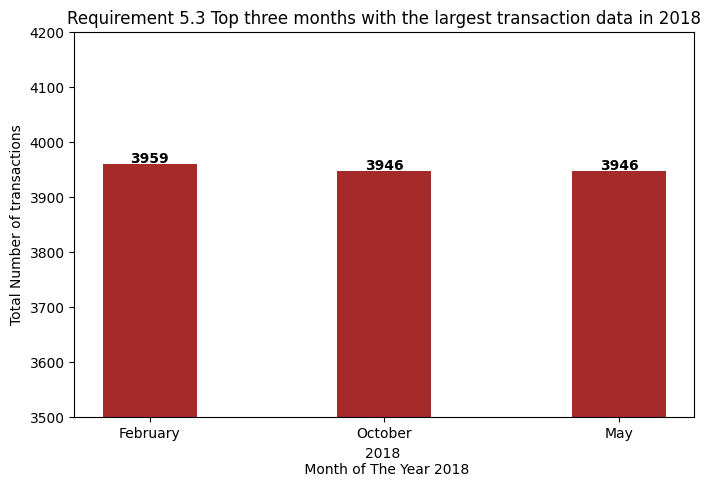

In [87]:
# 5.2 Find and plot the top three months with the largest transaction data.


cdf = credit_df.withColumn('Month', col('TIMEID').substr(5,2)).withColumn("Month_of_Year_2018", date_format(to_date("Month", "MM"), "MMMM"))


cdf2 = cdf.groupBy("Month_of_Year_2018").agg(count("TRANSACTION_VALUE").alias("TOTAL_NUMBER_OF_TRANSACTIONS"))\
    .sort(col("TOTAL_NUMBER_OF_TRANSACTIONS").desc())\
    .limit(3).toPandas()

print(cdf2.head())

fig = plt.figure(figsize = (8, 5))

graph= plt.bar(cdf2["Month_of_Year_2018"], cdf2["TOTAL_NUMBER_OF_TRANSACTIONS"], color ='Brown',width = 0.4)

#plt.xticks(rotation = 45, ha="right")
plt.title("Requirement 5.3 Top three months with the largest transaction data in 2018")
plt.xlabel("2018 \n Month of The Year 2018")
plt.ylabel("Total Number of transactions")
plt.ylim(3500,4200)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.001,
             str(cdf2["TOTAL_NUMBER_OF_TRANSACTIONS"][i]),
             ha='center',
             weight='bold')
    i+=1


plt.show()







    BRANCH_CITY  TOTAL_SUM_OF_TRANSACTIONS
0  NewBaltimore                    4370.18
1      Richmond                    4072.04
2    Brookfield                    4003.37
3      ElDorado                    3823.87
4  Kernersville                    3720.27
5   Chillicothe                    3697.16
6        Tacoma                    3651.74
7          Ames                    3603.67
8    Youngstown                    3603.25
9       Medford                    3594.35


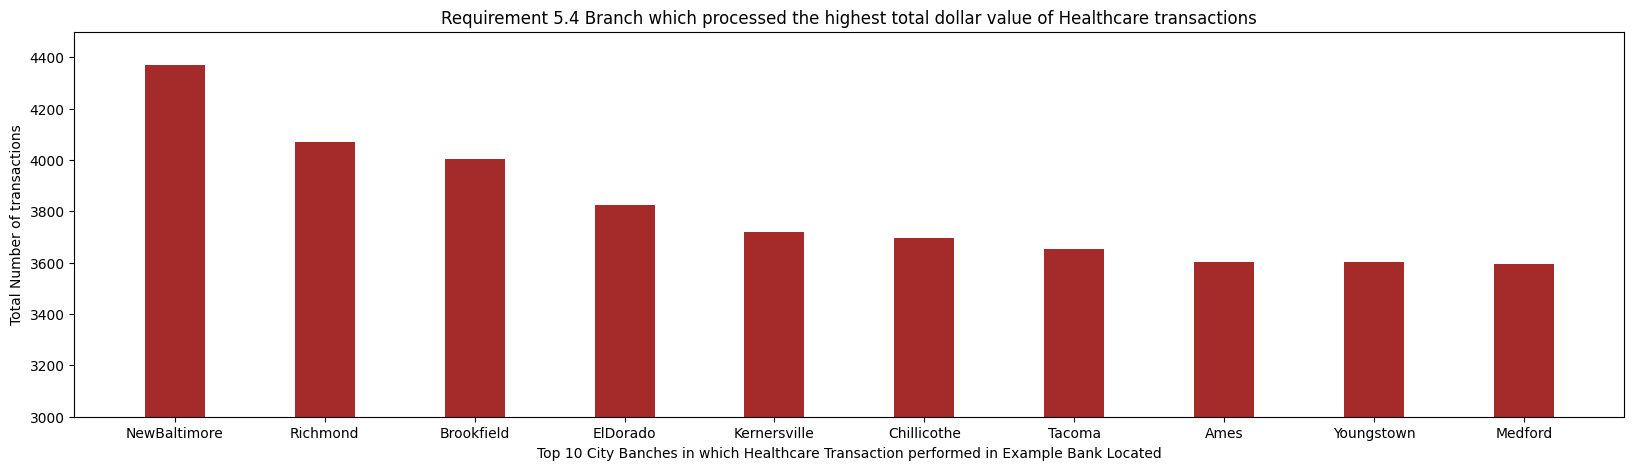

In [113]:
# 5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions. 

# Healthcare

credit_df2 = credit_df.join(branch_df, credit_df.BRANCH_CODE == branch_df.BRANCH_CODE, "left")



hcdf = credit_df2.filter(col("TRANSACTION_TYPE")== "Healthcare").groupBy("BRANCH_CITY").agg(round(sum("TRANSACTION_VALUE"),2).alias("TOTAL_SUM_OF_TRANSACTIONS"))\
    .sort(col("TOTAL_SUM_OF_TRANSACTIONS").desc()).limit(10).toPandas()

print(hcdf.head(10))
hcdf.count()


fig = plt.figure(figsize = (20, 5))

graph= plt.bar(hcdf["BRANCH_CITY"], hcdf["TOTAL_SUM_OF_TRANSACTIONS"], color ='Brown',width = 0.4)
#plt.xticks(rotation = 45, ha="right")
plt.title("Requirement 5.4 Branch which processed the highest total dollar value of Healthcare transactions")
plt.xlabel("Top 10 City Banches in which Healthcare Transaction performed in Example Bank Located")
plt.ylabel("Total Number of transactions")
plt.ylim(3000,4500)


plt.show()


In [9]:
# Overview of LOAN Application Data API
# Functional Requirements - LOAN Application Dataset

# 411 Create a Python program to GET (consume) data from the above API endpoint 
#for the loan application dataset.

url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

response = (requests.get(url))

jfile = response.json()


application_df = spark.createDataFrame(jfile)

application_df.show(5)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [10]:
# Find the status code of the above API endpoint.

# Hint: status code could be 200, 400, 404, 401.

# print request status_code
print(response)
print(response.status_code)

<Response [200]>
200


## Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). 
- challange: jdbc connect no longer worked.. gave error
    - Attempt: tried different synstax, including option for driver location
    - Attempt: Uninstall java 20 and installed java jdk 17
    - Attempt: deleted jdbc connection file and save new one for current spark version. Whole spakr session stopped working.
    - Attempt: checked and changed all the environmental variable as java location has changed now. Spark session started working now. 
    - Solution: since requirement asked to created table named "CDW-SAPP_loan_application" which has dash that is not accepted my mysql table name. 
                changed to underscore which than worked. 
    

In [11]:
#Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). 
# challange: jdbc connect no longer worked.. gave error. 

#The table name should be CDW-SAPP_loan_application in the database.
#Note: Use the “creditcard_capstone” database.



# application_df.write.format("jdbc") \
#               .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
#               .option("dbtable", "CDW_SAPP_loan_application") \
#               .option("user", "root") \
#               .option("password", "Password") \
#               .save()

Py4JJavaError: An error occurred while calling o93.save.
: java.sql.SQLSyntaxErrorException: You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near '-SAPP_loan_application (`Application_ID` TEXT , `Application_Status` TEXT , `Cre' at line 1
	at com.mysql.cj.jdbc.exceptions.SQLError.createSQLException(SQLError.java:120)
	at com.mysql.cj.jdbc.exceptions.SQLExceptionsMapping.translateException(SQLExceptionsMapping.java:122)
	at com.mysql.cj.jdbc.StatementImpl.executeUpdateInternal(StatementImpl.java:1333)
	at com.mysql.cj.jdbc.StatementImpl.executeLargeUpdate(StatementImpl.java:2106)
	at com.mysql.cj.jdbc.StatementImpl.executeUpdate(StatementImpl.java:1243)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.executeStatement(JdbcUtils.scala:1083)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.createTable(JdbcUtils.scala:913)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:81)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:47)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)


In [ ]:
# Find the status code of the above API endpoint.

# Hint: status code could be 200, 400, 404, 401.

# print request status_code
print(response)
print(response.status_code)

In [1]:
print(pd.__version__)
# 2.0.1

NameError: name 'pd' is not defined